In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline
plt.style.use('ggplot')

from sqlalchemy import create_engine
from tqdm import tqdm
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.feature_selection import FeatureSelector

%load_ext autoreload
%autoreload 2

In [2]:
modeling_df = pd.read_parquet('../../artifacts/20200920/modeling_df.parquet')
test_df = pd.read_parquet('../../artifacts/20200920/test_df.parquet')
modeling_df.shape, test_df.shape

((112599, 171), (88890, 171))

In [3]:
v1_features = ['transaction_amount', 'fico_score', 'vantage_score',
            'fraud_score_1', 'fraud_score_2', 'email_risk_score', 'phone_risk_score',  'all8220', 
            'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'bcc2800', 'iln5520', 'bcx3423', 'stu5031',
            'nr_direct_deposits', 'nr_past_returns', 'rolling_trns_as_pct_of_bal', 
            'nr_transactions_per_day', 'transaction_as_pct_of_balance', 
            'transaction_as_pct_of_bal_min', 'rolling_mean_acc_bal', 
              'real_ending_balance', # old 'account_ending_balance'
              'days_since_first_deposit' # old 'days_since_first_transaction'
              ]

features = ['transaction_amount', 'real_ending_balance', 'fico_score', 
            'vantage_score', 'all7120', 'all8220', 'bcc2800', 'bcc7120', 
            'bcx3423', 'iln5520', 'iqt9413', 'iqt9415', 'mtf5820', 'stu5031', 
            'credit_card_loan_amount', 'delinquencies_90_days', 'education_loan_amount',
            'mortgage_loan_amount', 'secured_loan_amount', 'total_outstanding_balance', 
            'total_tradelines_open', 'unsecured_loan_amount', 'giact_is_pass', 
            'giact_is_decline', 'giact_is_other', 'giact_nr_pass', 'giact_nr_decline',
            'giact_nr_other', 'fraud_score_1', 'fraud_score_2', 'address_risk_score', 
            'email_risk_score', 'phone_risk_score', 'name_address_correlation', 
            'name_email_correlation', 'name_phone_correlation', 'nr_social_profiles_found', 
            'days_since_first_deposit', 'lag_acc_open_first_transaction', 'first_deposit_amount', 
            'giact_time_since_first_link', 'giact_time_since_last_link', 'transaction_as_pct_of_balance', 
            'time_since_last_transaction', 'nr_past_returns', 'nr_returns_30d', 'nr_past_deposits',
            'nr_deposits_3d', 'nr_deposits_30d', 'nr_past_transactions', 'nr_transactions_3d',
            'nr_transactions_30d', 'pct_returned_deposits', 'pct_returned_deposits_30d',
            'nr_transactions_30d_div_nr_past_transactions', 'mean_account_balance_3d',
            'mean_account_balance_30d', 'std_account_balance_3d', 'std_account_balance_30d', 
            'sum_deposits_3d', 'sum_deposits_10d', 'sum_deposits_30d', 'sum_withdrawals_3d', 
            'sum_withdrawals_10d', 'sum_withdrawals_30d', 'mean_deposits_10d', 
            'mean_deposits', 'mean_deposits_10d_div_mean_deposits', 'mean_withdrawals_10d', 
            'mean_withdrawals', 'mean_withdrawals_10d_div_mean_withdrawals', 'max_deposits_3d', 
            'max_deposits_10d', 'max_deposits_10d_div_mean_deposits',
            'max_deposits_10d_div_mean_account_balance_30d', 'max_withdrawals', 
            'max_withdrawals_3d', 'max_withdrawals_10d', 'max_withdrawals_10d_div_mean_withdrawals',
            'nr_trans_ratio', 'bal_ratio', 'deposits_ratio', 'nr_direct_deposits', 'dollar_val_dd'] + v1_features

def remove_giact(features):
    return list(filter(lambda x: 'giact' not in x, features))

features = sorted(list(set(features)))
features = remove_giact(features)

### Apply our `FeatureSelector` Class
---

In [4]:
fsel = FeatureSelector(modeling_df, label_cols='is_returned', feature_cols=features)

#### WOE

In [5]:
fsel.get_woe(method='equal', num_bin_start=10, min_iv=0.02, min_samples_leaf=100, display=0) 
fsel.get_iv(method='equal', num_bin_start=10, min_iv=0.02, min_samples_leaf=100, display=0)
fsel.record_iv

producing WOE for all columns with numerical dtype


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/pandas/core/algorithms.py:1081: RuntimeWarning: invalid value encountered in double_scalars
  return a + (b - a) * fraction
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/pandas/core/algorithms.py:1081: RuntimeWarning: invalid value encountered in double_scalars
  return a + (b - a) * fraction
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/pandas/core/algorithms.py:1081: RuntimeWarning: invalid value encountered in double_scalars
  return a + (b - a) * fraction


processed  80  num attributes

WOE fitted
IV produced


,attr,iv
79,vantage_score,1.8953
5,bcc7120,1.5681
74,total_tradelines_open,1.3604
7,credit_card_loan_amount,1.2676
8,days_since_first_deposit,1.1937
...,...,...
56,pct_returned_deposits,0.0000
26,max_withdrawals,0.0000
47,nr_past_returns,0.0000
49,nr_returns_30d,0.0000


#### Correlation

In [6]:
corr = fsel.get_collinear(-0.6, 0.6)

correlation lowerbound: -0.6
correlation upperbound: 0.6
84 features have correlationbeyond bounds provided


In [7]:
fsel.record_collinear_pairs[:10]

[('all7120', 'bcc7120', 0.6601122147633398),
 ('all8220', 'fico_score', 0.6614249034603576),
 ('bal_ratio',
  'max_deposits_10d_div_mean_account_balance_30d',
  -0.999999999996758),
 ('bcc2800', 'bcc7120', 0.6828297637148093),
 ('bcc2800', 'bcx3423', 0.7890034610727087),
 ('bcc7120', 'bcx3423', 0.7063580852755199),
 ('days_since_first_deposit',
  'nr_transactions_30d_div_nr_past_transactions',
  -0.6561824281526911),
 ('deposits_ratio', 'nr_trans_ratio', 0.7897540442932123),
 ('dollar_val_dd', 'nr_direct_deposits', 0.6487163808739115),
 ('iqt9413', 'iqt9415', 0.6419049614123314)]

#### Missing Value

In [8]:
fsel.get_missing(0.1).head()

27 features with greater than                 0.1 missing values


,feature,missing_frac
64,std_account_balance_3d,0.579979
28,max_withdrawals_10d_div_mean_withdrawals,0.279692
63,std_account_balance_30d,0.233066
76,transaction_as_pct_of_bal_min,0.183749
61,rolling_trns_as_pct_of_bal,0.183749


#### Single Unique Value

In [9]:
fsel.get_single_unique()

1 features with a single unique value.


,feature,nr_unique
26,max_withdrawals,1


In [10]:
fsel.record_single_unique

,feature,nr_unique
26,max_withdrawals,1


#### Boruta

In [11]:
import lightgbm as lgb
count_pos = modeling_df['is_returned'].sum()
count_neg = (~modeling_df['is_returned']).sum()
pos_wgt_scaling_factor = count_neg / count_pos

In [ ]:
model = lgb.LGBMClassifier(boosting_type='gbdt', metric='auc', max_depth=4, 
                         n_estimators=250, colsample_bytree=0.6, 
                         learning_rate=0.1, reg_alpha=10, scale_pos_weight=pos_wgt_scaling_factor, 
                         min_data_in_leaf=50, random_state=222)
boruta_params = {
    'features': features,
    'drop_at': -15,
    'max_iter': 50,
    'random_state': 42, 
    'thresh': 0.3,
    'verbose': 1
}
%time fsel.get_boruta_importance(model, **boruta_params)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
CPU times: user 1d 14h 20min 21s, sys: 9.65 s, total: 1d 14h 20min 31s
Wall time: 4h 48min 13s


,feature,score,mean_importance
15,first_deposit_amount,50.0,5.933170
79,vantage_score,50.0,5.410654
13,email_risk_score,37.0,3.720315
7,credit_card_loan_amount,33.0,3.479086
58,phone_risk_score,31.0,3.501729
...,...,...,...
42,name_phone_correlation,-15.0,0.044414
19,iqt9413,-15.0,0.039189
40,name_address_correlation,-15.0,0.033964
9,delinquencies_90_days,-15.0,0.016546


In [ ]:
fsel.record_boruta_importance

,feature,score,mean_importance
15,first_deposit_amount,50.0,5.933170
79,vantage_score,50.0,5.410654
13,email_risk_score,37.0,3.720315
7,credit_card_loan_amount,33.0,3.479086
58,phone_risk_score,31.0,3.501729
...,...,...,...
42,name_phone_correlation,-15.0,0.044414
19,iqt9413,-15.0,0.039189
40,name_address_correlation,-15.0,0.033964
9,delinquencies_90_days,-15.0,0.016546


In [ ]:
fsel.record_boruta_importance.to_csv('../../artifacts/20200920/boruta_importance_iter1.csv')

<AxesSubplot:>

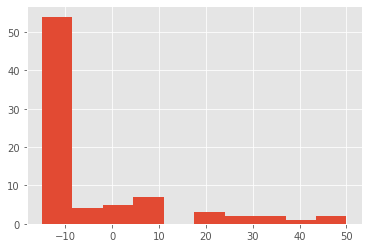

In [ ]:
fimp = fsel.record_boruta_importance
fimp.score.hist()

In [ ]:
boruta_features_iter1 = fimp[fimp.score>-10].feature.tolist()

#### Remove Highly Correlated Features from Boruta features

In [ ]:
corr_ = fsel.get_collinear(-0.6, 0.6, boruta_features_iter1)

correlation lowerbound: -0.6
correlation upperbound: 0.6
9 features have correlationbeyond bounds provided


In [ ]:
fsel.record_collinear_pairs

[('rolling_trns_as_pct_of_bal',
  'transaction_as_pct_of_balance',
  0.9743327345547994),
 ('rolling_trns_as_pct_of_bal',
  'transaction_as_pct_of_bal_min',
  0.9740042281759871),
 ('transaction_as_pct_of_balance',
  'transaction_as_pct_of_bal_min',
  0.9338571154141151),
 ('nr_transactions_30d_div_nr_past_transactions',
  'days_since_first_deposit',
  -0.6561824281526911),
 ('all7120', 'bcc7120', 0.6601122147633398),
 ('all8220', 'fico_score', 0.6614249034603576),
 ('sum_deposits_10d', 'std_account_balance_30d', 0.7401518754594796),
 ('sum_deposits_10d', 'mean_deposits_10d', 0.6733882003174857),
 ('std_account_balance_30d', 'mean_deposits_10d', 0.6400847218662203)]

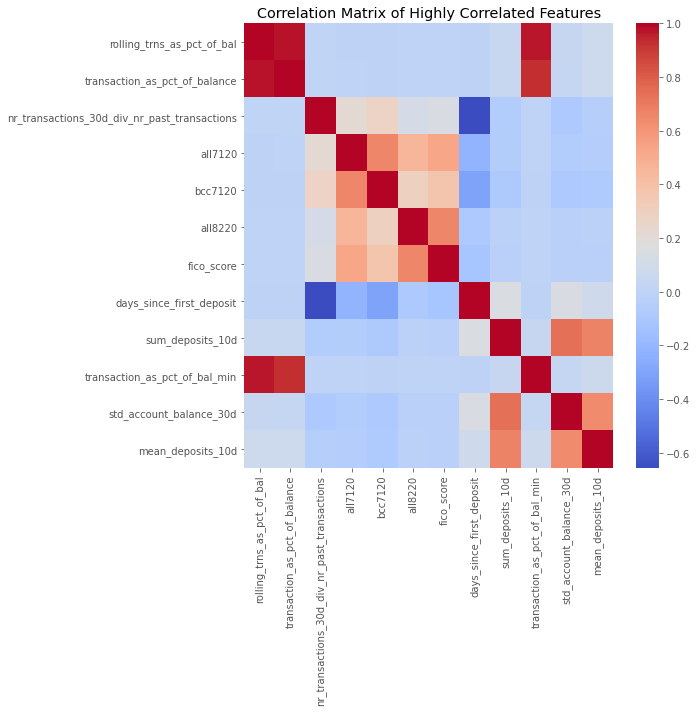

(<Figure size 720x720 with 2 Axes>,
 <AxesSubplot:title={'center':'Correlation Matrix of Highly Correlated Features'}>)

In [ ]:
fsel.plot_collinear()

### Save the states of the feature selector 

In [ ]:
path = '../../artifacts/20200920/feature_selector_dict.pkl'
fsel.save(path)